![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/3_1.Clinical_Entity_Resolvers_v2.4.5.ipynb)

# Clinical Entity Resolvers (v 2.4.5)

## Colab Setup

In [ ]:
import json

with open('license_keys.json') as f_in:
    license_keys = json.load(f_in)

license_keys.keys()

In [ ]:
# template for license_key.json

{'secret':"xxx",
'SPARK_NLP_LICENSE': 'aaa',
'JSL_OCR_LICENSE': 'bbb',
'AWS_ACCESS_KEY_ID':"ccc",
'AWS_SECRET_ACCESS_KEY':"ddd",
'JSL_OCR_SECRET':"eee"}

In [2]:
import os

# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed -q pyspark==2.4.4

secret = license_keys['secret']
os.environ['SPARK_NLP_LICENSE'] = license_keys['SPARK_NLP_LICENSE']
os.environ['JSL_OCR_LICENSE'] = license_keys['JSL_OCR_LICENSE']
os.environ['AWS_ACCESS_KEY_ID']= license_keys['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY'] = license_keys['AWS_SECRET_ACCESS_KEY']

! python -m pip install --upgrade spark-nlp-jsl==2.4.5  --extra-index-url https://pypi.johnsnowlabs.com/$secret

# Install Spark NLP
! pip install --ignore-installed -q spark-nlp==2.4.5

import sparknlp

print (sparknlp.version())

import json
import os
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession


from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl


def start(secret):
    builder = SparkSession.builder \
        .appName("Spark NLP Licensed") \
        .master("local[*]") \
        .config("spark.driver.memory", "8G") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "900M") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.4.5") \
        .config("spark.jars", "https://pypi.johnsnowlabs.com/"+secret+"/spark-nlp-jsl-2.4.5.jar")
      
    return builder.getOrCreate()


spark = start(secret) # if you want to start the session with custom params as in start function above
# sparknlp_jsl.start(secret)

openjdk version "1.8.0_242"
OpenJDK Runtime Environment (build 1.8.0_242-8u242-b08-0ubuntu3~18.04-b08)
OpenJDK 64-Bit Server VM (build 25.242-b08, mixed mode)
     |████████████████████████████████| 215.7MB 62kB/s 
     |████████████████████████████████| 204kB 46.1MB/s 
Looking in indexes: https://pypi.org/simple, https://pypi.johnsnowlabs.com/zMdiOE2Fn2
     |████████████████████████████████| 112kB 2.8MB/s 
2.4.5


In [4]:
sparknlp_jsl.version()

'2.4.5'

In [5]:
spark

# Clinical Resolvers

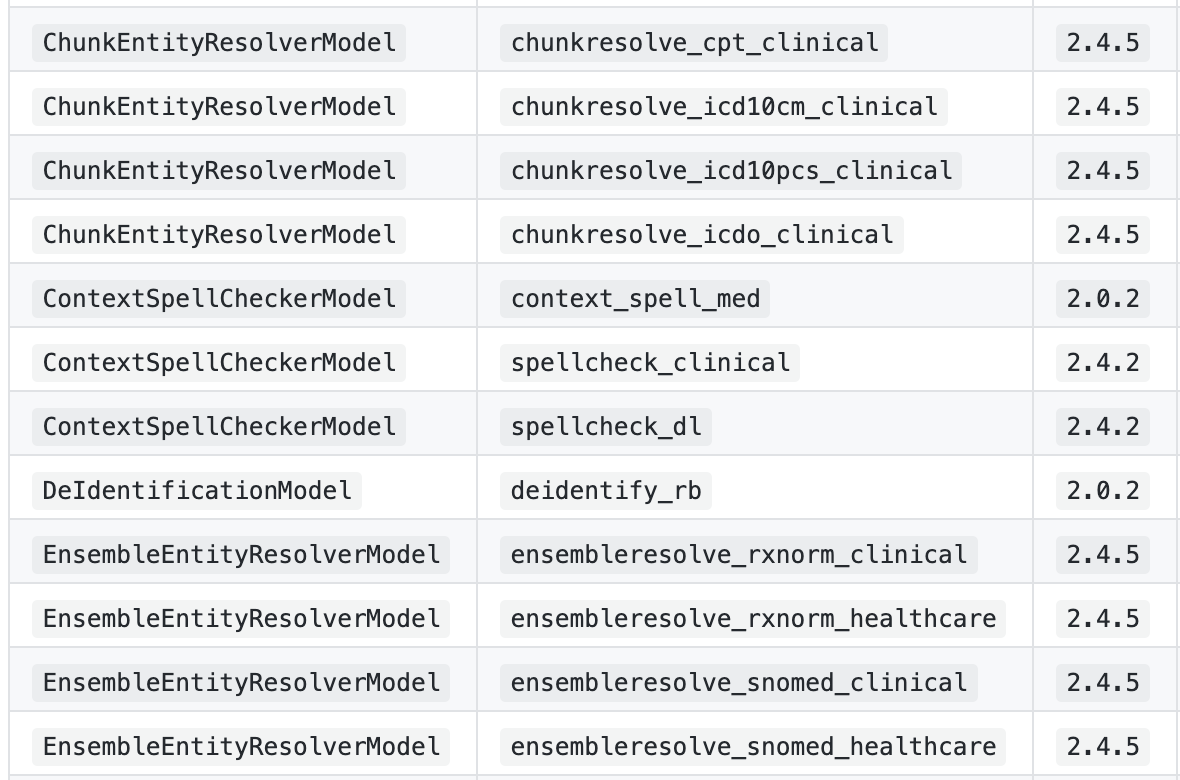

## Entity Resolvers for ICD-10

A common NLP problem in biomedical aplications is to identify the presence of clinical entities in a given text. This clinical entities could be diseases, symptoms, drugs, results of clinical investigations or others.

Other than providing the code in the "result" field it provides more metadata about the matching process:

- target_text -> Text to resolve
- resolved_text -> Best match text
- confidence -> Relative confidence for the top match (distance to probability)
- confidence_ratio -> Relative confidence for the top match. TopMatchConfidence / SecondMatchConfidence
- alternative_codes -> List of other plausible codes (in the KNN neighborhood)
- alternative_confidence_ratios -> Rest of confidence ratios
- all_k_results -> All resolved codes for metrics calculation purposes
- sentence -> SentenceId
- chunk -> ChunkId

In [ ]:
import sys, os, time
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.util import *
from sparknlp_jsl.annotator import *

from sparknlp.pretrained import ResourceDownloader

from pyspark.sql import functions as F
from pyspark.ml import Pipeline, PipelineModel

### Clinical NER Pipeline creation

In [ ]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP

documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line

sentenceDetector = SentenceDetector()\
  .setInputCols(["document"])\
  .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP

tokenizer = Tokenizer()\
  .setInputCols(["sentence"])\
  .setOutputCol("token")

The fourth annotator in the pipeline is "WordEmbeddingsModel". We will download a pretrained model available from "clinical/models" named "embeddings_clinical".

When running this cell your are advised to be patient.

First time you call this pretrained model it needs to be downloaded in your local.

The model size is about will download the embeddings_clinical corpus it takes a while.

The size is about 1.7Gb and will be saved typically in your home folder as

~HOMEFOLDER/cached_models/embeddings_clinical_en_2.0.2_2.4_1558454742956.zip

Next times you call it the model is loaded from your cached copy but even in that case it needs to be indexed each time so expect waiting up to 5 minutes (depending on your machine)

In [8]:
# WordEmbeddingsModel pretrained "embeddings_clinical" includes a model of 1.7Gb that needs to be downloaded

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


In [ ]:
!aws s3 cp s3://auxdata.johnsnowlabs.com/clinical/models/chunkresolve_icd10cm_clinical_en_2.4.2_2.4_1583085234727.zip chunkresolve_icd10cm_clinical_en_2.4.2_2.4_1583085234727.zip

download: s3://auxdata.johnsnowlabs.com/clinical/models/chunkresolve_icd10cm_clinical_en_2.4.2_2.4_1583085234727.zip to ./chunkresolve_icd10cm_clinical_en_2.4.2_2.4_1583085234727.zip


The fifth and final annotator in our NER pipeline is the pretrained `ner_clinical` NerDLModel avaliable from "clinical/models". It requires as input the "sentence", "token" and "embeddings" (clinical embeddings pretrained model) and will classify each token in four categories:

- PROBLEM: for patient problems

- TEST: for tests, labs, etc.

- TREATMENT: for treatments, medicines, etc.

- OTHER: for the rest of tokens.

In order to split those identified NER that are consecutive, the B prefix (as B-PROBLEM) will be used at the first token of each NER. The I prefix (as I-PROBLEM) will be used for the rest of tokens inside the NER.

In [9]:
# Named Entity Recognition for clinical concepts.

clinical_ner = NerDLModel.pretrained("ner_clinical", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("ner")

ner_clinical download started this may take some time.
Approximate size to download 13.8 MB
[OK!]


### Define the NER pipeline

Now we will define the actual pipeline that puts together the annotators we have created.

In [ ]:
# Build up the pipeline

pipeline_ner = Pipeline(
    stages = [
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    clinical_ner
  ])

### Create a SparkDataFrame with the content

Now we will create a sample Spark dataframe with our clinical note example.

In this example we are working over a unique clinical note. In production environments a table with several of those clinical notes could be distributed in a cluster and be run in large scale systems.

In [ ]:

clinical_note = (
    'A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years '
    'prior to presentation and subsequent type two diabetes mellitus (T2DM), one prior '
    'episode of HTG-induced pancreatitis three years prior to presentation, associated '
    'with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, '
    'presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting. '
    'Two weeks prior to presentation, she was treated with a five-day course of amoxicillin '
    'for a respiratory tract infection. She was on metformin, glipizide, and dapagliflozin '
    'for T2DM and atorvastatin and gemfibrozil for HTG. She had been on dapagliflozin for six months '
    'at the time of presentation. Physical examination on presentation was significant for dry oral mucosa; '
    'significantly, her abdominal examination was benign with no tenderness, guarding, or rigidity. Pertinent '
    'laboratory findings on admission were: serum glucose 111 mg/dl, bicarbonate 18 mmol/l, anion gap 20, '
    'creatinine 0.4 mg/dL, triglycerides 508 mg/dL, total cholesterol 122 mg/dL, glycated hemoglobin (HbA1c) '
    '10%, and venous pH 7.27. Serum lipase was normal at 43 U/L. Serum acetone levels could not be assessed '
    'as blood samples kept hemolyzing due to significant lipemia. The patient was initially admitted for '
    'starvation ketosis, as she reported poor oral intake for three days prior to admission. However, '
    'serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL, the anion gap '
    'was still elevated at 21, serum bicarbonate was 16 mmol/L, triglyceride level peaked at 2050 mg/dL, and '
    'lipase was 52 U/L. The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - '
    'the original sample was centrifuged and the chylomicron layer removed prior to analysis due to '
    'interference from turbidity caused by lipemia again. The patient was treated with an insulin drip '
    'for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL, within '
    '24 hours. Her euDKA was thought to be precipitated by her respiratory tract infection in the setting '
    'of SGLT2 inhibitor use. The patient was seen by the endocrinology service and she was discharged on '
    '40 units of insulin glargine at night, 12 units of insulin lispro with meals, and metformin 1000 mg '
    'two times a day. It was determined that all SGLT2 inhibitors should be discontinued indefinitely. She '
    'had close follow-up with endocrinology post discharge.'
)

data_ner = spark.createDataFrame([[clinical_note]]).toDF("text")

In [14]:
data_ner.show(truncate = 100)


+----------------------------------------------------------------------------------------------------+
|                                                                                                text|
+----------------------------------------------------------------------------------------------------+
|A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior ...|
+----------------------------------------------------------------------------------------------------+



### Transform / annotate the clinical note using the model.

In order to process the data with the new created model we have two options.

The first one would be to use the model to transform our clinical note by the command:

`output = model_ner.transform(data_ner)`

That would save in a Spakr DataFrame (output) the resuls of running the model over the clinical note.

However for small tests like this or for real-time request a LightPipelines is a simpler way of managing the data. It will return a dictionary (instead of a Spark DataFrame) with the results of the transformation

We will create a light_pipeline_ner using our model_ner and then will annotate the clinical_note using this light_pipeline.

In [ ]:
light_pipeline = LightPipeline(model_ner)
light_data = light_pipeline.annotate(clinical_note)

Now we have a dictionaty (light_data_ner) that contains the results of running the NER pipeline over our clinical note.

It contains the original document:

In [17]:
light_data['document'][0][0:100]


'A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to '

In [18]:
print("Number of sentences: {}".format(len(light_data['sentence'])))
print("")
for i in range(5):
    print("Sentence {}: {}".format(i, light_data['sentence'][i][0:80]))

Number of sentences: 17

Sentence 0: A 28-year-old female with a history of gestational diabetes mellitus diagnosed e
Sentence 1: Two weeks prior to presentation, she was treated with a five-day course of amoxi
Sentence 2: She was on metformin, glipizide, and dapagliflozin for T2DM and atorvastatin and
Sentence 3: She had been on dapagliflozin for six months at the time of presentation.
Sentence 4: Physical examination on presentation was significant for dry oral mucosa;


In [19]:
print("Number of tokens: {}".format(len(light_data['token'])))
print("")
for i in range(25):
    print("Token {}: {} ({})".format(i, light_data['token'][i][0:20], light_data['ner'][i]))
print("...")

Number of tokens: 436

Token 0: A (O)
Token 1: 28-year-old (O)
Token 2: female (O)
Token 3: with (O)
Token 4: a (O)
Token 5: history (O)
Token 6: of (O)
Token 7: gestational (B-PROBLEM)
Token 8: diabetes (I-PROBLEM)
Token 9: mellitus (I-PROBLEM)
Token 10: diagnosed (O)
Token 11: eight (O)
Token 12: years (O)
Token 13: prior (O)
Token 14: to (O)
Token 15: presentation (O)
Token 16: and (O)
Token 17: subsequent (O)
Token 18: type (B-PROBLEM)
Token 19: two (I-PROBLEM)
Token 20: diabetes (I-PROBLEM)
Token 21: mellitus (I-PROBLEM)
Token 22: ( (O)
Token 23: T2DM (B-PROBLEM)
Token 24: ), (I-PROBLEM)
...


Lets apply some HTML formating to see the results of the pipeline in a nicer layout:



In [ ]:
import random
from IPython.core.display import display, HTML


def get_color():
    r = lambda: random.randint(100,255)
    return '#%02X%02X%02X' % (r(),r(),r())

def get_NER_html (light_data):

    html_output=''
    
    problem_flag = False
    new_problem = []
    problem_list = []
    
    label_list = list(set([i.split('-')[1] for i in light_data['ner'] if i!='O']))
    
        
    label_color={}
    
    for l in label_list:
        
        label_color[l]=get_color()
            
    for index, this_token in enumerate(light_data['token']):

        try:
            ent = light_data['ner'][index].split('-')[1]
        except:
            ent = light_data['ner'][index]
        
       
        if ent in label_list:
            color = label_color[ent]
            html_output+='<SPAN style="background-color: {}">'.format(color) + this_token + " </SPAN>"
        else:
            html_output+=this_token + " "
        

    html_output += '</div>'
    html_output += '<div>Color codes:'
    

    for l in label_list:
        
        html_output += '<SPAN style="background-color: {}">{}</SPAN>, '.format(label_color[l],l)
   
    
    return display(HTML(html_output))


In [22]:
get_NER_html (light_data)

##  ICD10 coding Pipeline creation.

We will now create a new pipeline that from each of these problems will try to assign an ICD10 base on the content, the wordembeddings and some pretrained models for ICD10 annotation.

The architecture of this new pipeline will be as follows:

- DocumentAssembler (text -> document)

- SentenceDetector (document -> sentence)

- Tokenizer (sentence -> token)

- WordEmbeddingsModel ([sentence, token] -> embeddings)

- NerDLModel ([sentence, token, embeddings] -> ner)

- NerConverter (["sentence, token, ner] -> ner_chunk

- ChunkTokenizer (ner_chunk -> ner_chunk_tokenized)

- ICD10CMEntityResolverModel ([ner_chunk_tokenized, embeddings] -> resolution)

- ICD10PCSEntityResolverModel ([ner_chunk_tokenized, embeddings] -> resolution)

So from a text we end having a list of Named Entities (ner_chunk) and their ICD10 codes (resolution)

Most of the annotators in this pipeline have been already created for the previous pipeline, but we need to create four additional annotators: NerConverter, ChunkEmbeddigns, EntityResolverModel for ICD10CM and EntityResolverModel for ICD10PCS.

Now we define the new pipeline




In [25]:
# Named Entity Recognition concepts parser, transforms entities into CHUNKS (required for next step: assertion status)

ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")\
  .setWhiteList(['PROBLEM'])

chunk_embeddings = ChunkEmbeddings()\
    .setInputCols("ner_chunk", "embeddings")\
    .setOutputCol("chunk_embeddings")

chunk_tokenizer = ChunkTokenizer()\
    .setInputCols("ner_chunk")\
    .setOutputCol("ner_token")

# ICD resolution model

icd10cm_resolution = ChunkEntityResolverModel.pretrained("chunkresolve_icd10cm_clinical", "en", "clinical/models") \
  .setInputCols(["ner_token", "chunk_embeddings"]) \
  .setOutputCol("icd10cm_code") \
  .setDistanceFunction("COSINE")  \
  .setNeighbours(5)

chunkresolve_icd10cm_clinical download started this may take some time.
Approximate size to download 166.3 MB
[OK!]


In [ ]:

pipeline_icd10 = Pipeline(
    stages = [
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    clinical_ner,
    ner_converter,
    chunk_embeddings,
    chunk_tokenizer,
    icd10cm_resolution
  ])

model_icd10 = pipeline_icd10.fit(data_ner)


In [ ]:
light_pipeline_icd10 = LightPipeline(model_icd10)


In [29]:
text = light_data['document'][0]

text

'A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus (T2DM), one prior episode of HTG-induced pancreatitis three years prior to presentation, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting. Two weeks prior to presentation, she was treated with a five-day course of amoxicillin for a respiratory tract infection. She was on metformin, glipizide, and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG. She had been on dapagliflozin for six months at the time of presentation. Physical examination on presentation was significant for dry oral mucosa; significantly, her abdominal examination was benign with no tenderness, guarding, or rigidity. Pertinent laboratory findings on admission were: serum glucose 111 mg/dl, bicarbonate 18 mmol/l, anion gap 2

In [40]:
import pandas as pd


light_result = light_pipeline_icd10.annotate(text)

df = pd.DataFrame(list(zip(light_result['ner_chunk'], light_result['icd10cm_code'])),
                  columns = ['Problem','ICD10-CM-Code'])

df

,Problem,ICD10-CM-Code
0,gestational diabetes mellitus,O24424
1,type two diabetes mellitus,E11630
2,"T2DM),",E1165
3,HTG-induced pancreatitis,B252
4,an acute hepatitis,B172
5,obesity,E661
6,a body mass index,Z6831
7,BMI) of 33.5 kg/m2,Z6845
8,polyuria,R358
9,polydipsia,R631


In [ ]:
def get_icd10_codes (light_model, text):

  full_light_result = light_model.fullAnnotate(text)

  chunks = []
  codes = []
  resolved= []
  begin = []
  end = []
  resolutions=[]

  for chunk, code in zip(full_light_result[0]['ner_chunk'], full_light_result[0]['icd10cm_code']):
          
      begin.append(chunk.begin)
      end.append(chunk.end)
      chunks.append(chunk.result)
      codes.append(code.result) 
      resolved.append(code.metadata['resolved_text'])
      resolutions.append(code.metadata['all_k_resolutions'])
      
  import pandas as pd

  df = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 
                    'icd10_cm_code':codes, 'resolved_text':resolved,
                    'target_text':resolutions})

  return df




In [43]:
df = get_icd10_codes (light_pipeline_icd10, text)

df

,chunks,begin,end,icd10_cm_code,resolved_text,target_text
0,gestational diabetes mellitus,39,67,O24424,"Gestational diabetes mellitus in childbirth, i...","Gestational diabetes mellitus in childbirth, i..."
1,type two diabetes mellitus,128,153,E11630,Type 2 diabetes mellitus with periodontal disease,Type 2 diabetes mellitus with periodontal dise...
2,"T2DM),",156,161,E1165,Type 2 diabetes mellitus with hyperglycemia,Type 2 diabetes mellitus with hyperglycemia:::...
3,HTG-induced pancreatitis,184,207,B252,Cytomegaloviral pancreatitis,Cytomegaloviral pancreatitis:::Alcohol-induced...
4,an acute hepatitis,260,277,B172,Acute hepatitis E,Acute hepatitis E:::Other specified acute vira...
5,obesity,284,290,E661,Drug-induced obesity,Drug-induced obesity:::Drug-induced obesity:::...
6,a body mass index,297,313,Z6831,"Body mass index (BMI) 31.0-31.9, adult","Body mass index (BMI) 31.0-31.9, adult:::Body ..."
7,BMI) of 33.5 kg/m2,316,333,Z6845,"Body mass index (BMI) 70 or greater, adult","Body mass index (BMI) 70 or greater, adult:::B..."
8,polyuria,373,380,R358,Other polyuria,Other polyuria:::Polydipsia:::Polydipsia:::Gly...
9,polydipsia,383,392,R631,Polydipsia,Polydipsia:::Polydipsia:::Glycosuria:::Other p...


In [33]:
output = model_icd10.transform(data_ner).cache()

output.select(F.explode(F.arrays_zip("ner_chunk.result","ner_chunk.metadata",
                                     "icd10cm_code.result","icd10cm_code.metadata")).alias("icd10cm_result")) \
.select(F.expr("icd10cm_result['0']").alias("chunk"),
        F.expr("icd10cm_result['1'].entity").alias("entity"),
        F.expr("icd10cm_result['3'].resolved_text").alias("resolved_text"),
        F.expr("icd10cm_result['2']").alias("code"),
        F.expr("icd10cm_result['3'].all_k_resolutions").alias("cms"))\
.distinct() \
.toPandas()


,chunk,entity,resolved_text,code,cms
0,starvation ketosis,PROBLEM,Propionic acidemia,E71121,Propionic acidemia:::Propionic acidemia:::Type...
1,Her euDKA,PROBLEM,"Abnormal finding of blood chemistry, unspecified",R799,"Abnormal finding of blood chemistry, unspecifi..."
2,HTG-induced pancreatitis,PROBLEM,Cytomegaloviral pancreatitis,B252,Cytomegaloviral pancreatitis:::Alcohol-induced...
3,significant lipemia,PROBLEM,Gestational [pregnancy-induced] hypertension w...,O134,Gestational [pregnancy-induced] hypertension w...
4,guarding,PROBLEM,Dysuria,R300,Dysuria:::Periumbilic rebound abdominal tender...
5,vomiting,PROBLEM,Bilious vomiting,R1114,Bilious vomiting:::Projectile vomiting:::Bilio...
6,polydipsia,PROBLEM,Polydipsia,R631,Polydipsia:::Polydipsia:::Glycosuria:::Other p...
7,a respiratory tract infection,PROBLEM,Acute nasopharyngitis [common cold],J00,Acute nasopharyngitis [common cold]:::Herpesvi...
8,her respiratory tract infection,PROBLEM,Acute nasopharyngitis [common cold],J00,Acute nasopharyngitis [common cold]:::Diseases...
9,HTG,PROBLEM,Pure hyperglyceridemia,E781,Pure hyperglyceridemia:::Pure hyperglyceridemi...


In [45]:
text = 'He has a brain damage and lung cancer'

df = get_icd10_codes(light_pipeline_icd10, text)

df

,chunks,begin,end,icd10_cm_code,resolved_text,target_text
0,a brain damage,7,20,G931,"Anoxic brain damage, not elsewhere classified","Anoxic brain damage, not elsewhere classified:..."
1,lung cancer,26,36,J676,Maple-bark-stripper's lung,Maple-bark-stripper's lung:::Mushroom-worker's...


# RxNorm Resolver

In [46]:
rxnorm_resolution = EnsembleEntityResolverModel.pretrained("ensembleresolve_rxnorm_clinical", "en", "clinical/models")\
    .setInputCols("ner_token","chunk_embeddings").setOutputCol("rxnorm_result")

ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")\
  .setWhiteList(['TREATMENT'])


pipeline_rx = Pipeline(
    stages = [
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    clinical_ner,
    ner_converter,
    chunk_embeddings,
    chunk_tokenizer,
    rxnorm_resolution
  ])

model_rxnorm = pipeline_rx.fit(data_ner)


ensembleresolve_rxnorm_clinical download started this may take some time.
Approximate size to download 783.3 MB
[OK!]


In [47]:
text = light_data['document'][0]
text

'A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus (T2DM), one prior episode of HTG-induced pancreatitis three years prior to presentation, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting. Two weeks prior to presentation, she was treated with a five-day course of amoxicillin for a respiratory tract infection. She was on metformin, glipizide, and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG. She had been on dapagliflozin for six months at the time of presentation. Physical examination on presentation was significant for dry oral mucosa; significantly, her abdominal examination was benign with no tenderness, guarding, or rigidity. Pertinent laboratory findings on admission were: serum glucose 111 mg/dl, bicarbonate 18 mmol/l, anion gap 2

In [55]:
data = spark.createDataFrame([[text]]).toDF("text")
        
output = model_rxnorm.transform(data)

output.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|    chunk_embeddings|           ner_token|       rxnorm_result|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|A 28-year-old fem...|[[document, 0, 24...|[[document, 0, 42...|[[token, 0, 0, A,...|[[word_embeddings...|[[named_entity, 0...|[[chunk, 499, 509...|[[word_embeddings...|[[token, 499, 509...|[[entity, 499, 50...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----

In [57]:
output.select(F.explode(F.arrays_zip("ner_chunk.result","ner_chunk.metadata","rxnorm_result.result","rxnorm_result.metadata")).alias("rxnorm_result")) \
    .select(F.expr("rxnorm_result['0']").alias("chunk"),
            F.expr("rxnorm_result['1'].entity").alias("entity"),
            F.expr("rxnorm_result['3'].all_k_resolutions").alias("target_text"),
            F.expr("rxnorm_result['2']").alias("code"),
            F.expr("rxnorm_result['3'].confidence_ratio").alias("conf")).show(truncate = 50)

+--------------------+---------+--------------------------------------------------+-------+------+
|               chunk|   entity|                                       target_text|   code|  conf|
+--------------------+---------+--------------------------------------------------+-------+------+
|         amoxicillin|TREATMENT|Amoxicillin:::amoxicillin:::AMOXICILLIN:::Amoxi...|    723|1.0000|
|           metformin|TREATMENT|Metformin:::metformin:::METFORMIN:::Metformin::...|   6809|1.0000|
|           glipizide|TREATMENT|Glipizide:::GLIPIZIDE:::glipizide:::Glipizide::...|   4821|1.0000|
|       dapagliflozin|TREATMENT|DAPAGLIFLOZIN:::dapagliflozin:::Dapagliflozin::...|1488564|1.0000|
|        atorvastatin|TREATMENT|Atorvastatin:::atorvastatin:::ATORVASTATIN:::At...|  83367|1.0000|
|         gemfibrozil|TREATMENT|Gemfibrozil:::GEMFIBROZIL:::gemfibrozil:::Gemfi...|   4719|1.0000|
|       dapagliflozin|TREATMENT|DAPAGLIFLOZIN:::dapagliflozin:::Dapagliflozin::...|1488564|1.0000|
|     an i

## Snomed Resolver

In [58]:
ner_snomed_resolver = \
    EnsembleEntityResolverModel.pretrained("ensembleresolve_snomed_clinical","en","clinical/models")\
    .setInputCols("ner_token","chunk_embeddings").setOutputCol("snomed_result")

ensembleresolve_snomed_clinical download started this may take some time.
Approximate size to download 592.9 MB
[OK!]


In [ ]:
ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")

pipeline_snomed = Pipeline(
    stages = [
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    clinical_ner,
    ner_converter,
    chunk_embeddings,
    chunk_tokenizer,
    ner_snomed_resolver
  ])

model_snomed = pipeline_snomed.fit(data_ner)

In [63]:
data = spark.createDataFrame([[text]]).toDF("text")
        
output = model_snomed.transform(data)

output.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|    chunk_embeddings|           ner_token|       snomed_result|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|A 28-year-old fem...|[[document, 0, 24...|[[document, 0, 42...|[[token, 0, 0, A,...|[[word_embeddings...|[[named_entity, 0...|[[chunk, 39, 67, ...|[[word_embeddings...|[[token, 39, 49, ...|[[entity, 39, 67,...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----

In [65]:

output.select(F.explode(F.arrays_zip("ner_chunk.begin",
                                  "ner_chunk.end",
                                      "ner_chunk.result", "ner_chunk.metadata", "snomed_result.result", "snomed_result.metadata")).alias("snomed_result")) \
.select(F.expr("snomed_result['2']").alias("ner"),
        F.expr("snomed_result['3'].entity").alias("entity"),
        F.expr("snomed_result['0']").alias("begin"),
        F.expr("snomed_result['1']").alias("end"),
        F.expr("snomed_result['4']").alias("snomed_code"),
        F.expr("snomed_result['5'].resolved_text").alias("resolved_text"),
        F.expr("round(snomed_result['5'].confidence_ratio,2)").alias("confidence_ratio")) \
.distinct().show(truncate=50)

+-------------------------------+---------+-----+----+-----------+------------------------------------------+----------------+
|                            ner|   entity|begin| end|snomed_code|                             resolved_text|confidence_ratio|
+-------------------------------+---------+-----+----+-----------+------------------------------------------+----------------+
|     type two diabetes mellitus|  PROBLEM|  128| 153|   44054006|                  Diabetes mellitus type 2|             1.0|
|                         T2DM),|  PROBLEM|  156| 161|   84999002|                             Bowen disease|            1.07|
|                        obesity|  PROBLEM|  284| 290|  414916001|                                   Obesity|             0.5|
|                            HTG|  PROBLEM|  643| 645|   46803007|                                   Glucoma|             1.0|
|    interference from turbidity|  PROBLEM| 1811|1837|    9123002|                       Increased turbidity|  

# ICD-O Resolver

A common NLP problem in medical applications is to identify histology behaviour in documented cancer studies.

In this example we will use Spark-NLP to identify and resolve histology behavior expressions and resolve them to an ICD-O code.

In [ ]:
text = '''
A 35-year-old African-American man was referred to our urology clinic by his primary care physician for consultation about a large left scrotal mass. The patient reported a 3-month history of left scrotal swelling that had progressively increased in size and was associated with mild left scrotal pain. He also had complaints of mild constipation, with hard stools every other day. He denied any urinary complaints. On physical examination, a hard paratesticular mass could be palpated in the left hemiscrotum extending into the left groin, separate from the left testicle, and measuring approximately 10 × 7 cm in size. A hard, lower abdominal mass in the suprapubic region could also be palpated in the midline. The patient was admitted urgently to the hospital for further evaluation with cross-sectional imaging and blood work.
Laboratory results, including results of a complete blood cell count with differential, liver function tests, coagulation panel, and basic chemistry panel, were unremarkable except for a serum creatinine level of 2.6 mg/dL. Typical markers for a testicular germ cell tumor were within normal limits: the beta–human chorionic gonadotropin level was less than 1 mIU/mL and the alpha fetoprotein level was less than 2.8 ng/mL. A CT scan of the chest, abdomen, and pelvis with intravenous contrast was obtained, and it showed large multifocal intra-abdominal, retroperitoneal, and pelvic masses (Figure 1). On cross-sectional imaging, a 7.8-cm para-aortic mass was visualized compressing the proximal portion of the left ureter, creating moderate left hydroureteronephrosis. Additionally, three separate pelvic masses were present in the retrovesical space, each measuring approximately 5 to 10 cm at their largest diameter; these displaced the bladder anteriorly and the rectum posteriorly.
The patient underwent ultrasound-guided needle biopsy of one of the pelvic masses on hospital day 3 for definitive diagnosis. Microscopic examination of the tissue by our pathologist revealed cellular islands with oval to elongated, irregular, and hyperchromatic nuclei; scant cytoplasm; and invading fibrous tissue—as well as three mitoses per high-powered field (Figure 2). Immunohistochemical staining demonstrated strong positivity for cytokeratin AE1/AE3, vimentin, and desmin. Further mutational analysis of the cells detected the presence of an EWS-WT1 fusion transcript consistent with a diagnosis of desmoplastic small round cell tumor.
'''


And let's build a SparkNLP pipeline with the following stages:

- DocumentAssembler: Entry annotator for our pipelines; it creates the data structure for the Annotation Framework

- SentenceDetector: Annotator to pragmatically separate complete sentences inside each document

- Tokenizer: Annotator to separate sentences in tokens (generally words)

- WordEmbeddings: Vectorization of word tokens, in this case using word embeddings trained from PubMed, ICD10 and other clinical resources.

- EntityResolver: Annotator that performs search for the KNNs, in this case trained from ICDO Histology Behavior.

In order to find cancer related chunks, we are going to use a pretrained Search Trie wrapped up in our TextMatcher Annotator; and to identify treatments/procedures we are going to use our good old NER.

- TextMatcher: Trained with a Cancer Glossary and an augmented dataset from JSL Data Market this annotator makes sure to return just found phrases in a search Trie. In this case ICDO phrases.

- NerDLModel: TensorFlow based Named Entity Recognizer, trained to extract PROBLEMS, TREATMENTS and TESTS

- NerConverter: Chunk builder out of tokens tagged by the Ner Model

## TextMatcher Strategy


In [76]:
icdo_ner = NerDLModel.pretrained("ner_bionlp", "en", "clinical/models")\
    .setInputCols("sentence", "token", "embeddings")\
    .setOutputCol("icdo_ner")

icdo_chunk = NerConverter().setInputCols("sentence","token","icdo_ner").setOutputCol("icdo_chunk")

icdo_chunk_embeddings = ChunkEmbeddings()\
    .setInputCols("icdo_chunk", "embeddings")\
    .setOutputCol("icdo_chunk_embeddings")

icdo_chunk_resolver = ChunkEntityResolverModel.pretrained("chunkresolve_icdo_clinical", "en", "clinical/models")\
    .setInputCols("token","icdo_chunk_embeddings")\
    .setOutputCol("tm_icdo_code")

ner_bionlp download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
chunkresolve_icdo_clinical download started this may take some time.
Approximate size to download 8.2 MB
[OK!]


In [ ]:
pipeline_icdo = Pipeline().setStages([

    documentAssembler, 
    sentenceDetector, 
    tokenizer, 
    word_embeddings, 
    
    clinical_ner, 
    ner_converter, 
    chunk_embeddings,
    chunk_tokenizer,
    ner_snomed_resolver,
    
    icdo_ner,
    icdo_chunk,
    icdo_chunk_embeddings, 
    icdo_chunk_resolver
])

model_icdo = pipeline_icdo.fit(data_ner)

In [78]:
data = spark.createDataFrame([[text]]).toDF("text")
        
output = model_icdo.transform(data)

output.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+
|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|    chunk_embeddings|           ner_token|       snomed_result|            icdo_ner|          icdo_chunk|icdo_chunk_embeddings|        tm_icdo_code|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+
|
A 35-year-old Af...|[[document, 0, 24...|[[document, 1, 14...|[[token, 1, 1, A,...|[[word_embeddings...|[[n

In [79]:
output.withColumn("note",F.monotonically_increasing_id()).select(F.col("note"),F.explode(F.arrays_zip("icdo_chunk.result","tm_icdo_code.result","tm_icdo_code.metadata")).alias("icdo_result")) \
.select("note",
        F.expr("icdo_result['0']").alias("chunk"),
        F.expr("substring(icdo_result['2'].resolved_text,0,25)").alias("resolved_text"),
        F.expr("icdo_result['1']").alias("code"),
        F.expr("round(icdo_result['2'].confidence_ratio,2)").alias("confidence")) \
.distinct() \
.orderBy(["note","confidence"], ascending=[True,False]) \
.toPandas()

,note,chunk,resolved_text,code,confidence
0,8589934592,beta–human chorionic,Choriocarcinoma,9100/3,3.37
1,8589934592,abdominal,Immunoproliferative small,9764/3,1.72
2,8589934592,left groin,Renal cell carcinoma,8312/3,1.44
3,8589934592,left hemiscrotum,Renal cell carcinoma,8312/3,1.43
4,8589934592,alpha fetoprotein,Immunoproliferative small,9764/3,1.43
5,8589934592,left scrotal,Renal cell carcinoma,8312/3,1.42
6,8589934592,pelvic masses,Renal cell carcinoma,8312/3,1.38
7,8589934592,needle biopsy,Renal cell carcinoma,8312/3,1.36
8,8589934592,blood,"Leukemia, NOS",9800/3,1.28
9,8589934592,vimentin,Polyembryoma,9072/3,1.20


In [80]:
output.select(F.explode(F.arrays_zip("ner_chunk.result","ner_chunk.metadata","snomed_result.result","snomed_result.metadata")).alias("icdo_result")) \
.select(F.expr("substring(icdo_result['0'],0,35)").alias("chunk"),
        F.expr("icdo_result['1'].entity").alias("entity"),
        #F.expr("icdo_result['3'].target_text").alias("target_text"),
        F.expr("substring(icdo_result['3'].resolved_text,0,35)").alias("resolved_text"),
        #F.expr("icdo_result['2']").alias("code"),
        #F.expr("icdo_result['2'].alternative_codes").alias("alternative_codes"),
        F.expr("round(icdo_result['3'].confidence_ratio,2)").alias("conf")
       ) \
.distinct() \
.orderBy("conf",ascending=False)\
.toPandas()

,chunk,entity,resolved_text,conf
0,a complete blood cell count,TEST,Complete blood count,2.54
1,an EWS-WT1 fusion transcript,TEST,Fusion oncogene protein,1.66
2,coagulation panel,TEST,Blood coagulation panel,1.55
3,mild left scrotal pain,PROBLEM,Acute scrotal pain,1.54
4,urinary complaints,PROBLEM,Multiple complaints,1.51
5,a 7.8-cm para-aortic mass,PROBLEM,Observation of a mass,1.43
6,desmin,TEST,Desmin (substance),1.32
7,further evaluation,TEST,Preanaesthesia evaluation,1.24
8,"A CT scan of the chest, abdomen, an",TEST,"Computed tomography of chest, abdom",1.23
9,a serum creatinine level,TEST,Corrected serum creatinine level,1.19
